In [1]:
!nvidia-smi

Tue Feb 20 13:02:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/FloodNet-Supervised_v1.0.zip'

In [3]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from skimage.transform import resize
from keras.utils import to_categorical
from matplotlib.patches import Rectangle
from sklearn.metrics import average_precision_score

seed = 42
SIZE_X = 256
SIZE_Y = 256
n_channels = 3
n_classes = 10
Batch_size = 4
EPOCHS = 100
MODEL = 'unet'
BACKBONE = 'Vanilla Mini CNN'

parent_directory = r'/content/FloodNet-Supervised_v1.0'

In [4]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}

color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128],
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3))))
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [5]:
def load_images(parent_directory, split='train'):
    images = []
    masks = []

    image_folder_path = f'{parent_directory}/{split}/{split}-org-img'
    for img_path in tqdm(glob.glob(os.path.join(image_folder_path, "*.jpg"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

        mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [6]:
def preprocess_data(images, masks, unet_preporcessing=None):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)

    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], -1, n_classes))

    return images, masks

def reverse_masks_shape(masks):
    masks = masks.reshape((masks.shape[0], SIZE_X, SIZE_Y, n_classes))
    return masks

In [10]:
#Load the images
train_images, train_masks = load_images(parent_directory, split='train')
val_images, val_masks = load_images(parent_directory, split='val')

100%|██████████| 1445/1445 [06:22<00:00,  3.78it/s]


TRAIN: Images loaded: 1445
TRAIN: Masks loaded: 1445


100%|██████████| 450/450 [01:59<00:00,  3.77it/s]

VAL: Images loaded: 450
VAL: Masks loaded: 450


In [11]:
data_to_save = {
    'train_images': train_images,
    'train_masks': train_masks,
    'val_images': val_images,
    'val_masks': val_masks
}

pickle_file_path = f'/content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/segmentation_models/dataset/train_and_val_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Data saved to /content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/segmentation_models/dataset/train_and_val_data(256x256).pickle
Shapes of loaded data:
Train Images: (1445, 256, 256, 3)
Train Masks: (1445, 256, 256)
Val Images: (450, 256, 256, 3)
Val Masks: (450, 256, 256)


In [5]:
pickle_file_path = f'/content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/segmentation_models/dataset/train_and_val_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

train_images = loaded_data['train_images']
train_masks = loaded_data['train_masks']
val_images = loaded_data['val_images']
val_masks = loaded_data['val_masks']

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 448, 448, 3)
Train Masks: (1445, 448, 448)
Val Images: (450, 448, 448, 3)
Val Masks: (450, 448, 448)


In [12]:
train_images, train_masks = preprocess_data(train_images, train_masks)
val_images, val_masks = preprocess_data(val_images, val_masks)

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Shapes of loaded data:
Train Images: (1445, 256, 256, 3)
Train Masks: (1445, 65536, 10)
Val Images: (450, 256, 256, 3)
Val Masks: (450, 65536, 10)


In [13]:
!pip install keras_segmentation
!pip install segmentation_models

In [7]:
from keras_segmentation.models.all_models import unet, pspnet, fcn, segnet
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

model = None

if MODEL == 'unet':
    if BACKBONE == 'Vanilla Mini CNN':
        model = unet.unet_mini(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN':
        model = unet.unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = unet.resnet50_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = unet.vgg_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'MobileNet':
        model = unet.mobilenet_unet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
elif MODEL == 'pspnet':
    if BACKBONE == 'Vanilla CNN':
        model = pspnet.pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN (50)':
        model = pspnet.pspnet_50(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'Vanilla CNN (101)':
        model = pspnet.pspnet_101(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = pspnet.resnet50_pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = pspnet.vgg_pspnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
elif MODEL == 'segnet':
    if BACKBONE == 'Vanilla CNN':
        model = segnet.segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'ResNet-50':
        model = segnet.resnet50_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'VGG-16':
        model = segnet.vgg_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
    elif BACKBONE == 'MobileNet':
        model = segnet.mobilenet_segnet(n_classes=n_classes , input_height=SIZE_X, input_width=SIZE_Y)
else:
    raise ValueError('Unknown model')

if model:
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    model.summary()
else:
    print('Model not found')

Segmentation Models: using `tf.keras` framework.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['dropout[0][0]']             
                                           

In [15]:
model.input_shape, model.output_shape

((None, 256, 256, 3), (None, 65536, 10))

In [16]:
train_images.shape, train_masks.shape

((1445, 256, 256, 3), (1445, 65536, 10))

In [34]:
history = model.fit(x=train_images, y=train_masks, batch_size=Batch_size, epochs=EPOCHS, validation_data=(val_images, val_masks))

Epoch 1/100
362/362 [==============================] - 18s 40ms/step - loss: 0.9089 - iou_score: 0.3596 - val_loss: 0.8747 - val_iou_score: 0.3663
Epoch 2/100
362/362 [==============================] - 11s 29ms/step - loss: 0.8321 - iou_score: 0.3966 - val_loss: 0.8295 - val_iou_score: 0.3982
Epoch 3/100
362/362 [==============================] - 11s 29ms/step - loss: 0.7794 - iou_score: 0.4284 - val_loss: 0.7654 - val_iou_score: 0.4474
Epoch 4/100
362/362 [==============================] - 11s 29ms/step - loss: 0.7571 - iou_score: 0.4412 - val_loss: 0.7245 - val_iou_score: 0.4569
Epoch 5/100
362/362 [==============================] - 11s 29ms/step - loss: 0.7374 - iou_score: 0.4563 - val_loss: 0.7936 - val_iou_score: 0.4331
Epoch 6/100
362/362 [==============================] - 11s 30ms/step - loss: 0.7074 - iou_score: 0.4766 - val_loss: 0.6649 - val_iou_score: 0.5097
Epoch 7/100
362/362 [==============================] - 11s 29ms/step - loss: 0.7032 - iou_score: 0.4825 - val_loss: 0.

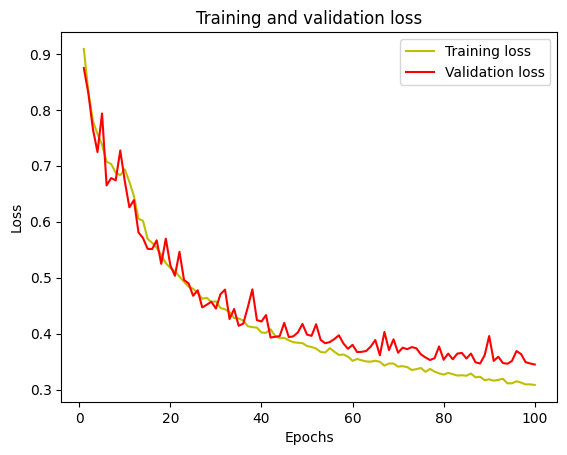

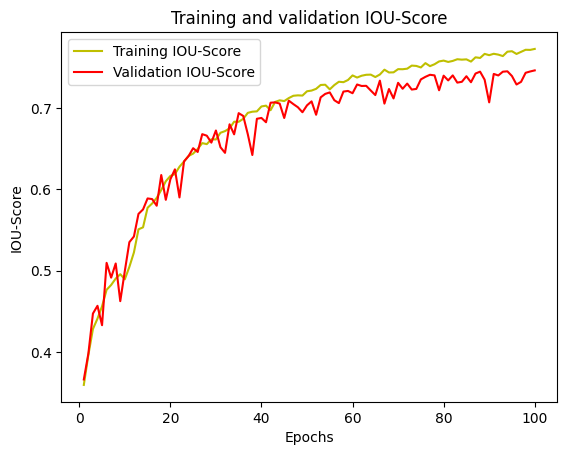

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [36]:
model.save(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y}).hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
dir = '/content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/keras-segmentation/Unet_weights_256x256'
model.load_weights(f'{dir}/weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y}).hdf5')

In [ ]:
test_parent_directory = r'/content/FloodNet-Supervised_v1.0'

test_images, test_masks = load_images(test_parent_directory, split='test')
test_images_seperate = test_images

test_images, test_masks = preprocess_data(test_images, test_masks)

In [39]:
data_to_save = {
    'test_images': test_images,
    'test_masks': test_masks,
    'test_images_seperate': test_images_seperate
}

pickle_file_path = f'/content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/segmentation_models/dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Data saved to /content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/segmentation_models/dataset/test_data(256x256).pickle
Shapes of loaded data:
Test Images: (448, 256, 256, 3)
Test Masks: (448, 65536, 10)


In [10]:
pickle_file_path = f'/content/drive/MyDrive/Post-Flood Disaster Management/Code/Segmentation/segmentation_models/dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 256, 256, 3)
Test Masks: (448, 65536, 10)


In [11]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  73.4454333782196 %


In [12]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)

print(y_pred.shape)
print(test_masks.shape)

predicted_masks = reverse_masks_shape(y_pred)
test_masks = reverse_masks_shape(test_masks)

print(predicted_masks.shape)
print(test_masks.shape)

predicted_masks = np.argmax(predicted_masks, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

14/14 [==============================] - 1s 41ms/step
(448, 65536, 10)
(448, 65536, 10)
(448, 256, 256, 10)
(448, 256, 256, 10)


In [13]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0:
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.51552844
IoU for each class:
Building Flooded: 0.6453368663787842
Building Non-Flooded: 0.6056528687477112
Road Flooded: 0.37982377409935
Road Non-Flooded: 0.7082857489585876
Water: 0.6029483079910278
Tree: 0.7264900207519531
Vehicle: 0.26065438985824585
Pool: 0.3463427722454071
Grass: 0.8364803791046143
Mean IoU (excluding Background): 0.5680016


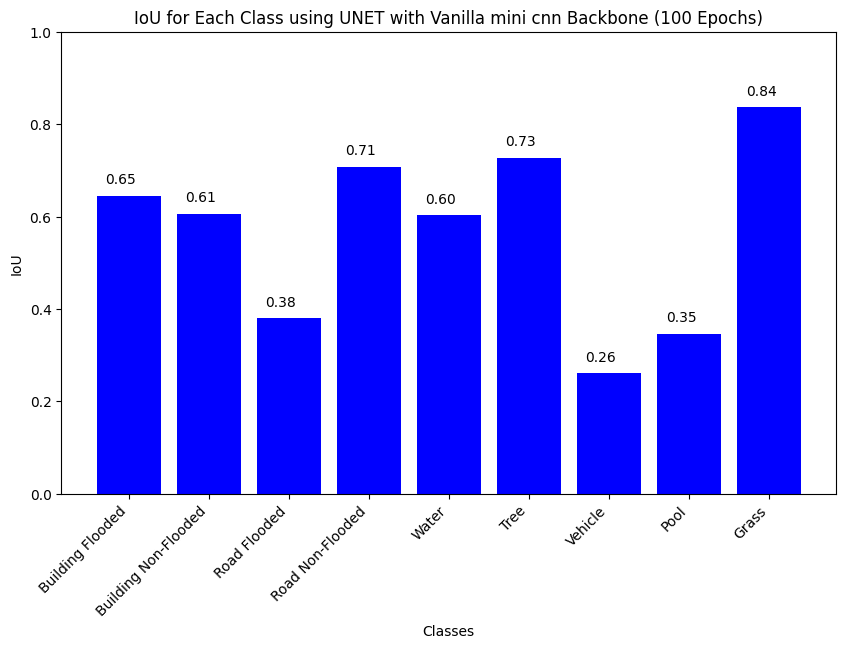

In [14]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [15]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


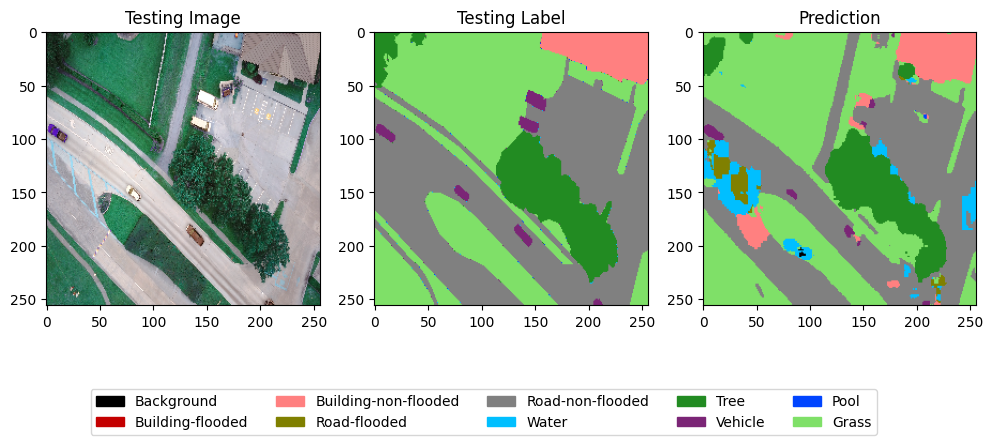

In [16]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


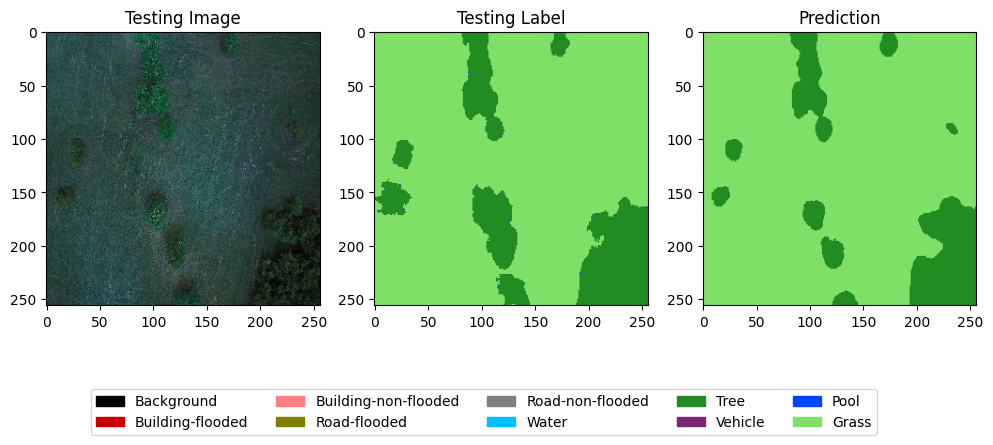

In [17]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


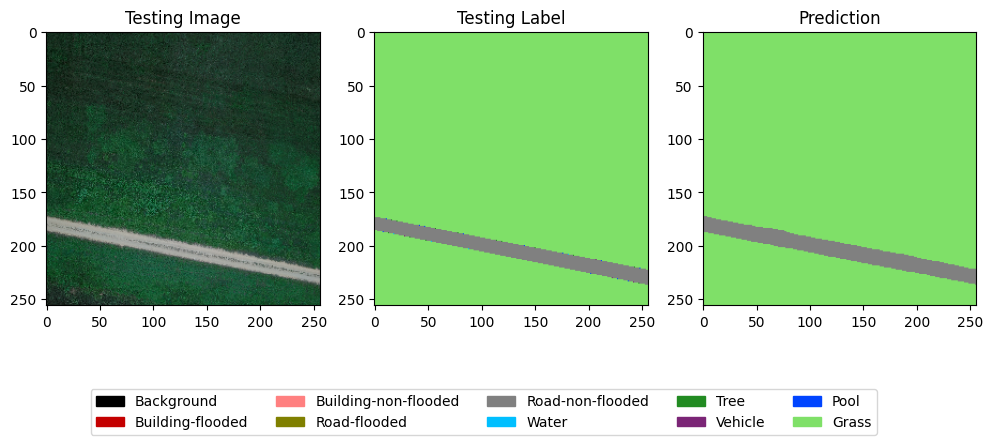

In [18]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


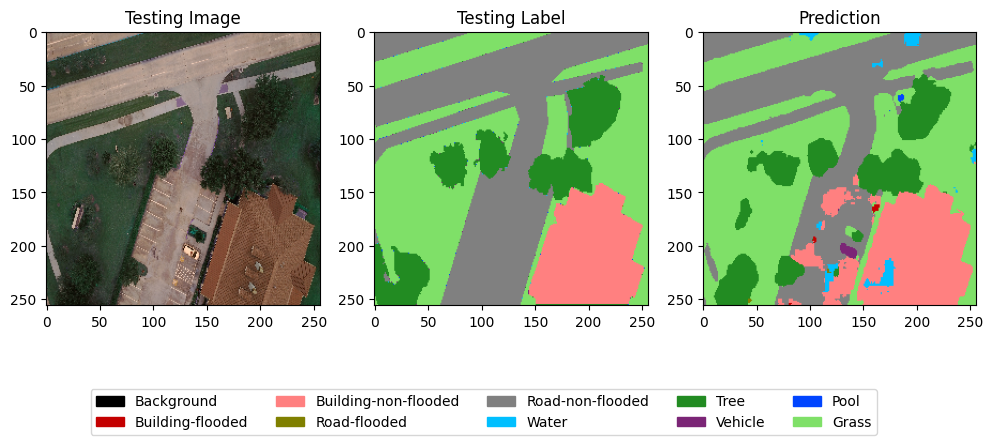

In [19]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)


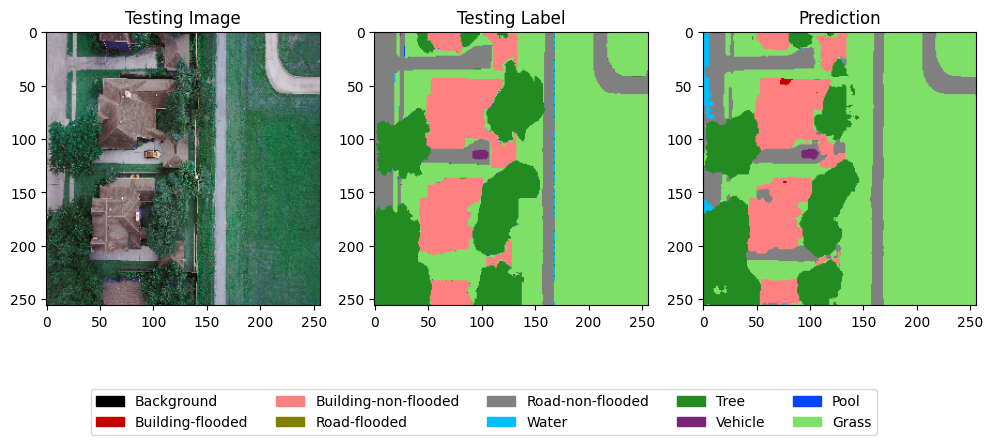

In [20]:
display_random_function()